In [67]:
!pip install -qU langchain\
    langchain-community\
    langchain-together\
    langchain-core\
    faiss-cpu\
    faiss-gpu\
    langgraph\
    sentence-transformers\
    gradio\
    pypdf

In [68]:
import requests
from bs4 import BeautifulSoup
from langchain.document_loaders import PyPDFLoader
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
from langchain.embeddings import CacheBackedEmbeddings
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_together import ChatTogether
from langchain_community.vectorstores import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from IPython.core.display import Markdown
from langchain_core.messages import HumanMessage, AIMessage
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from typing import TypedDict, Annotated
from langchain_core.documents import Document
from langchain_core.messages.base import BaseMessage
from langgraph.graph import StateGraph, END
import operator
import os

In [69]:
os.environ["TAVILY_API_KEY"] = "..."
os.environ["TOGETHER_API_KEY"] = "..."

1

In [70]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

url = "https://stanford.edu/~jurafsky/slp3/"

try:
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, 'html.parser')

    unwanted_links = [
        'https://stanford.edu/~jurafsky/slp3/ed3bookfeb3_2024.pdf'
    ]

    pdf_links = []

    for a in soup.find_all('a', href=True):
        href = urljoin(url, a['href'])
        if href.endswith('.pdf') and 'slides' not in href and href not in unwanted_links:
            pdf_links.append(href)

    print(pdf_links)

except requests.exceptions.RequestException as e:
    print(f"Error fetching page: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

['https://stanford.edu/~jurafsky/slp3/2.pdf', 'https://stanford.edu/~jurafsky/slp3/3.pdf', 'https://stanford.edu/~jurafsky/slp3/4.pdf', 'https://stanford.edu/~jurafsky/slp3/5.pdf', 'https://stanford.edu/~jurafsky/slp3/6.pdf', 'https://stanford.edu/~jurafsky/slp3/7.pdf', 'https://stanford.edu/~jurafsky/slp3/8.pdf', 'https://stanford.edu/~jurafsky/slp3/9.pdf', 'https://stanford.edu/~jurafsky/slp3/10.pdf', 'https://stanford.edu/~jurafsky/slp3/11.pdf', 'https://stanford.edu/~jurafsky/slp3/13.pdf', 'https://stanford.edu/~jurafsky/slp3/14.pdf', 'https://stanford.edu/~jurafsky/slp3/15.pdf', 'https://stanford.edu/~jurafsky/slp3/16.pdf', 'https://stanford.edu/~jurafsky/slp3/17.pdf', 'https://stanford.edu/~jurafsky/slp3/18.pdf', 'https://stanford.edu/~jurafsky/slp3/19.pdf', 'https://stanford.edu/~jurafsky/slp3/20.pdf', 'https://stanford.edu/~jurafsky/slp3/21.pdf', 'https://stanford.edu/~jurafsky/slp3/22.pdf', 'https://stanford.edu/~jurafsky/slp3/23.pdf', 'https://stanford.edu/~jurafsky/slp3/A.pd

In [72]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)

split_documents = []

for i, doc in enumerate(documents):
    try:
        chunks = text_splitter.split_documents(doc)
        split_documents.extend(chunks)
        print(f"Document {i+1}/{len(documents)} split into {len(chunks)} chunks.")
    except Exception as e:
        print(f"Error splitting document {i+1}: {e}")

for i in range(min(3, len(split_documents))):
    print(f"Chunk {i+1}:\n{split_documents[i]}\n")

print(f"Total split documents: {len(split_documents)}")

Document 1/29 split into 102 chunks.
Document 2/29 split into 101 chunks.
Document 3/29 split into 77 chunks.
Document 4/29 split into 72 chunks.
Document 5/29 split into 123 chunks.
Document 6/29 split into 78 chunks.
Document 7/29 split into 92 chunks.
Document 8/29 split into 85 chunks.
Document 9/29 split into 98 chunks.
Document 10/29 split into 76 chunks.
Document 11/29 split into 118 chunks.
Document 12/29 split into 76 chunks.
Document 13/29 split into 98 chunks.
Document 14/29 split into 115 chunks.
Document 15/29 split into 78 chunks.
Document 16/29 split into 83 chunks.
Document 17/29 split into 98 chunks.
Document 18/29 split into 78 chunks.
Document 19/29 split into 87 chunks.
Document 20/29 split into 132 chunks.
Document 21/29 split into 117 chunks.
Document 22/29 split into 47 chunks.
Document 23/29 split into 48 chunks.
Document 24/29 split into 62 chunks.
Document 25/29 split into 73 chunks.
Document 26/29 split into 37 chunks.
Document 27/29 split into 87 chunks.
Doc

In [74]:

texts = [chunk.page_content for chunk in split_documents]

embedding_function = HuggingFaceEmbeddings(show_progress=True, multi_process=True)

try:
    vector_store = FAISS.from_documents(documents=split_documents, embedding=embedding_function)
    print("Vector store created successfully.")
except Exception as e:
    print(f"Error creating vector store: {e}")

# Save the vector store locally
try:
    save_path = "vector_store"
    vector_store.save_local(save_path)
    print(f"Vector store saved locally at {save_path}.")
except Exception as e:
    print(f"Error saving vector store: {e}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Vector store created successfully.
Vector store saved locally at vector_store.


In [75]:
def create_retriever_and_perform_retrieval(vector_store, queries, k=3):
    """
    Create a retriever from the vector store, perform retrieval for each query,
    and print the results.

    Args:
    - vector_store: The vector store object containing the document embeddings.
    - queries: A list of queries to retrieve relevant documents for.
    - k: The number of top relevant documents to retrieve for each query.

    Returns:
    - None
    """
    # Step 1: Create a Retriever
    retriever = vector_store.as_retriever(search_kwargs={"k": k})

    # Display the output schema of the retriever (optional)
    print(retriever.output_schema)

    # Step 2: Perform Retrieval and Print Results
    for query in queries:
        results = retriever.get_relevant_documents(query)
        print(f"Query: {query}\n")
        for i, result in enumerate(results):
            print(f"Result {i + 1}:\n{result}\n")
        print("-" * 80)

# Define three new queries related to NLP
queries = [
    "What is word embedding?",
    "Explain the Unet architecture.",
    "How Teniss players do their excersises?"
]

# Call the function to create retriever and perform retrieval
create_retriever_and_perform_retrieval(vector_store, queries)

<class 'pydantic.v1.main.VectorStoreRetrieverOutput'>
Query: What is word embedding?

Result 1:
page_content='embeddings can be off-the-shelf word2vec embeddings, or can be computed directly' metadata={'source': 'https://stanford.edu/~jurafsky/slp3/21.pdf', 'page': 6}

Result 2:
page_content='20 CHAPTER 6 • V ECTOR SEMANTICS AND EMBEDDINGS
1WCaardvark
zebrazebraaardvarkapricotapricot|V||V|+12V& =target wordscontext & noisewords…
…1..d…
…
Figure 6.13 The embeddings learned by the skipgram model. The algorithm stores two
embeddings for each word, the target embedding (sometimes called the input embedding)
and the context embedding (sometimes called the output embedding). The parameter θthat
the algorithm learns is thus a matrix of 2 |V|vectors, each of dimension d, formed by concate-
nating two matrices, the target embeddings Wand the context+noise embeddings C.
6.8.2 Learning skip-gram embeddings
The learning algorithm for skip-gram embeddings takes as input a corpus of text,
and a chos

In [86]:

llm = ChatTogether(
    model_name="meta-llama/Llama-3-70b-chat-hf",
    temperature=0
)

# Example 1: Basic LLM invocation with a raw prompt
def invoke_llm_with_raw_prompt():
    raw_prompt = "Hello, I'm a master's student at the University of Tehran, studying NLP."
    response = llm.invoke(raw_prompt).content
    pprint(response)

# Example 2: Using a template to classify a query
def classify_query():
    prompt_template = ChatPromptTemplate.from_template(
        template="Please classify the following query as 'NLP', 'CS', or 'General':\n\nQuery: {query}\n\nClassification:"
    )
    prompt = prompt_template.invoke({"query": "word embedding"})
    response = llm.invoke(prompt).content
    pprint(response)

# Example 3: Chaining prompts for classification
def chain_classification():
    prompt_template = ChatPromptTemplate.from_template(
        template="Please classify the following query as 'NLP', 'CS', or 'General':\n\nQuery: {query}\n\nClassification:"
    )
    classification_chain = prompt_template | llm
    response = classification_chain.invoke({"query": "please tell me about World War 2?"}).content
    pprint(response)

# Example 4: Router prompt with Pydantic parsing
def router_prompt_with_pydantic():
    router_prompt_template = (
        "Please choose how to route user queries: VectorStore or SearchEngine.\n"
        "VectorStore contains data on natural language processing, computer science, and general topics. If the query fits these topics, choose VectorStore.\n"
        "If the query doesn't fit these topics, choose SearchEngine.\n"
        "If the query doesn't match any available categories, return 'None'.\n"
        "Provide only the tool's name.\n"
        "{output_instructions}\n"
        "Query: {query}"
    )
    prompt = ChatPromptTemplate.from_template(template=router_prompt_template)

    class ChosenTool(BaseModel):
        tool_name: Literal['None', "VectorStore", "SearchEngine"] = Field(
            ..., description="Select the tool to route user queries: 'None', 'VectorStore', or 'SearchEngine'."
        )

    question_router_parser = PydanticOutputParser(pydantic_object=ChosenTool)
    output_instructions = question_router_parser.get_format_instructions()

    router_chain = prompt | llm | question_router_parser
    response = router_chain.invoke({
        "query": "talk about LLM dialogue bot?",
        "output_instructions": output_instructions
    })

    # Extract the content from the response after parsing
    parsed_response = response
    pprint(parsed_response)

# Execute examples
invoke_llm_with_raw_prompt()
classify_query()
chain_classification()
router_prompt_with_pydantic()


("Hello! Nice to meet you! Congratulations on pursuing your master's degree in "
 "NLP at the University of Tehran. That's a fascinating field with many "
 'exciting applications.\n'
 '\n'
 'What specific areas of NLP interest you the most? Are you working on any '
 "research projects or thesis topics that you'd like to share? I'm here to "
 'listen and help if I can.')
'Classification: NLP'
'Classification: General'
ChosenTool(tool_name='VectorStore')


In [87]:

from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults()

query = "tell me about the preprocessing operation in NLP?"

retrieved_documents = tool.invoke(query)

print(retrieved_documents)




[{'url': 'https://towardsdatascience.com/nlp-text-preprocessing-steps-tools-and-examples-94c91ce5d30', 'content': 'Retrieved from https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02\n--\n--\nWritten by Viet Hoang Tran Duong\nTowards Data Science\nML Engineer | CS Senior @ Minerva | Founder @ Vizly | AI/ML developer and just a person who loves cooking and traveling\nHelp\nStatus\nAbout\nCareers\nBlog\nPrivacy\nTerms\nText to speech\nTeams Sign up\nSign in\nSign up\nSign in\nNLP Text Preprocessing: Steps, tools, and examples\nThe standard step by step approach to preprocessing text for NLP tasks.\n Viet Hoang Tran Duong\nFollow\nTowards Data Science\n--\nListen\nShare\nText data is everywhere, from your daily Facebook or Twitter newsfeed to textbooks and customer feedback. All the code in this post is very abstract and can be applied to many data projects (you only need to change to the name of columns, and all should work properly). A big part of your mac

In [88]:
from langchain.tools.tavily_search import TavilySearchResults
from langchain_core.documents.base import Document

# Initialize TavilySearchResults tool
tavily_tool = TavilySearchResults()

def search_engine_chain(query):
    # Retrieve search results for the query
    search_results = tavily_tool.invoke(query)

    print(f"Total search results found: {len(search_results)}\n")

    documents = []
    # Process the first 5 search results
    for result in search_results[:5]:
        print(f"Result: {result}")
        page_content = result['content']
        metadata = {"source": result['url']}
        document = Document(page_content=page_content, metadata=metadata)
        documents.append(document)

    return documents

query = "tell me about the preprocessing operation in NLP?"
retrieved_documents = search_engine_chain(query)

print("\nRetrieved Documents:")
for doc in retrieved_documents:
    print(f"URL: {doc.metadata['source']}")
    print(f"Content: {doc.page_content}\n")


Total search results found: 5

Result: {'url': 'https://towardsdatascience.com/nlp-text-preprocessing-steps-tools-and-examples-94c91ce5d30', 'content': 'Retrieved from https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02\n--\n--\nWritten by Viet Hoang Tran Duong\nTowards Data Science\nML Engineer | CS Senior @ Minerva | Founder @ Vizly | AI/ML developer and just a person who loves cooking and traveling\nHelp\nStatus\nAbout\nCareers\nBlog\nPrivacy\nTerms\nText to speech\nTeams Sign up\nSign in\nSign up\nSign in\nNLP Text Preprocessing: Steps, tools, and examples\nThe standard step by step approach to preprocessing text for NLP tasks.\n Viet Hoang Tran Duong\nFollow\nTowards Data Science\n--\nListen\nShare\nText data is everywhere, from your daily Facebook or Twitter newsfeed to textbooks and customer feedback. All the code in this post is very abstract and can be applied to many data projects (you only need to change to the name of columns, and all should 

In [89]:

# Initialize ChatTogether model
llm = ChatTogether(
    model_name="meta-llama/Llama-3-70b-chat-hf",
    temperature=0
)

# Designing the prompt template for relevance evaluation
prompt_template = ChatPromptTemplate.from_template(
    template="Determine if the following document is 'relevant' or 'irrelevant' to the given query i just want a single word as 'relevant' or 'irrelevant':\n\nQuery: {query}\n\nDocument: {document}\n\nClassification:"
)

# Step 2: Example function to classify a document's relevance
def classify_document_relevance(query, document):
    prompt = prompt_template.invoke({
        "query": query,
        "document": document
    })
    response = llm.invoke(prompt).content
    return response.strip()

# Step 3: Example Usage
query = "what is word war 2?"
query2 = "what is word embedding?"
# document = "Word embedding is a type of word representation that allows words to be represented as vectors in a continuous vector space where words with similar meanings are closer together."
document=retrieved_documents
# Classify the relevance of the document to the query
classification = classify_document_relevance(query, document)
print(f"Query: {query}")
print(f"Document: {document}")
print(f"Classification: {classification}")
classification = classify_document_relevance(query2, document)
print(f"Query: {query2}")
print(f"Document: {document}")
print(f"Classification: {classification}")


Query: what is word war 2?
Document: [Document(metadata={'source': 'https://towardsdatascience.com/nlp-text-preprocessing-steps-tools-and-examples-94c91ce5d30'}, page_content='Retrieved from https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02\n--\n--\nWritten by Viet Hoang Tran Duong\nTowards Data Science\nML Engineer | CS Senior @ Minerva | Founder @ Vizly | AI/ML developer and just a person who loves cooking and traveling\nHelp\nStatus\nAbout\nCareers\nBlog\nPrivacy\nTerms\nText to speech\nTeams Sign up\nSign in\nSign up\nSign in\nNLP Text Preprocessing: Steps, tools, and examples\nThe standard step by step approach to preprocessing text for NLP tasks.\n Viet Hoang Tran Duong\nFollow\nTowards Data Science\n--\nListen\nShare\nText data is everywhere, from your daily Facebook or Twitter newsfeed to textbooks and customer feedback. All the code in this post is very abstract and can be applied to many data projects (you only need to change to the name of c

In [90]:
router_prompt_template = ChatPromptTemplate.from_template(
    template="""
    You have to choose routing user queries to either a VectorStore, a SearchEngine, or Fallback (None).
    Your VectorStore contains data about natural language processing, computer science, and general topics. If the given query is about one of these topics, choose VectorStore.
    If the query is not related to any of these topics, choose SearchEngine.
    If the query is not related to anything the chatbot can handle, give back the string None.
    Give me only and only the name of the tool you chose and nothing more.
    {output_instructions}
    Query: {query}
    """
)

# Step 2: Define the Model using ChatTogether
llm = ChatTogether(
    model_name="meta-llama/Llama-3-70b-chat-hf",
    temperature=0.0
)

# Step 3: Define the Output Parser
class ChosenTool(BaseModel):
    tool_name: Literal['None', "VectorStore", "SearchEngine"] = Field(description="The tool chosen by LLM during question routing stage")

question_router_parser = PydanticOutputParser(pydantic_object=ChosenTool)

# Integrate the parser with the prompt and model
router_chain = router_prompt_template | llm | question_router_parser

# Example Usage
query = "Tell me about the history of the Internet."

# Define the output instructions for the parser
output_instructions = question_router_parser.get_format_instructions()

# Invoke the chain
res = router_chain.invoke({
    "query": query,
    "output_instructions": output_instructions
})

# Print the result
res


ChosenTool(tool_name='VectorStore')

In [91]:
# Import necessary libraries
from langchain.prompts import ChatPromptTemplate
from langchain_together import ChatTogether
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import Literal

# Step 1: Prepare the Prompt
fallback_prompt_template = ChatPromptTemplate.from_template(
    template="""
    You have to choose routing user queries to either a VectorStore, a SearchEngine, or Fallback (None).
    Your VectorStore contains data about natural language processing, computer science, and general topics. If the given query is about one of these topics, choose VectorStore.
    If the query is not related to any of these topics, choose SearchEngine.
    If the query is not related to anything the chatbot can handle, give back the string None.
    Provide only the name of the tool you chose and nothing more.
    Query: {query}
    """
)

# Step 2: Define the Model using ChatTogether
llm = ChatTogether(
    model_name="meta-llama/Llama-3-70b-chat-hf",
    temperature=0.9  # Higher temperature for more varied responses
)

# Step 3: Define the Output Parser
class ChosenTool(BaseModel):
    tool_name: Literal['None', "VectorStore", "SearchEngine"]

def parse_chosen_tool(text: str) -> ChosenTool:
    # Directly parse the text response from the model
    return ChosenTool(tool_name=text.strip())

# Custom output parser
class CustomOutputParser:
    def __init__(self, parse_function):
        self.parse_function = parse_function

    def parse(self, text: str):
        return self.parse_function(text)

# Instantiate the custom parser
custom_output_parser = CustomOutputParser(parse_chosen_tool)

# Integrate the parser with the prompt and model
class Chain:
    def __init__(self, prompt, model, parser):
        self.prompt = prompt
        self.model = model
        self.parser = parser

    def invoke(self, inputs):
        query = inputs['query']
        prompt_text = self.prompt.format(query=query)
        model_output = self.model.invoke(prompt_text).content
        return self.parser.parse(model_output)

fallback_chain = Chain(fallback_prompt_template, llm, custom_output_parser)

# Example Usage
query = "Tell me about the history of the Internet."

# Invoke the chain
res = fallback_chain.invoke({
    "query": query
})

# Print the result
print(res)


tool_name='VectorStore'


In [ ]:

# Step 1: Prepare the Prompt
generate_prompt_template = ChatPromptTemplate.from_template(
    template="""
    You have been given a query along with a set of documents. Your task is to provide a detailed response to the query based on the information contained within these documents.

    Query: {query}
    Documents: {documents}

    Provide a comprehensive answer to the query based on the provided documents.
    """
)

# Step 2: Define the Model using ChatTogether
llm = ChatTogether(
    model_name="meta-llama/Llama-3-70b-chat-hf",
    temperature=0.7  # Setting temperature for controlled response
)

# Step 3: Define the Output Parser
class FinalResponse(BaseModel):
    response: str

def parse_final_response(text: str) -> FinalResponse:
    # Directly parse the text response from the model
    return FinalResponse(response=text.strip())

# Custom output parser
class CustomOutputParser:
    def __init__(self, parse_function):
        self.parse_function = parse_function

    def parse(self, text: str):
        return self.parse_function(text)

# Instantiate the custom parser
final_output_parser = CustomOutputParser(parse_final_response)

# Integrate the parser with the prompt and model
class GenerateWithContextChain:
    def __init__(self, prompt, model, parser):
        self.prompt = prompt
        self.model = model
        self.parser = parser

    def invoke(self, inputs):
        query = inputs['query']
        documents = inputs['documents']
        prompt_text = self.prompt.format(query=query, documents=documents)
        model_output = self.model.invoke(prompt_text).content
        return self.parser.parse(model_output)

generate_with_context_chain = GenerateWithContextChain(generate_prompt_template, llm, final_output_parser)

# Example Usage
query = "What are the key points in the history of the Internet?"
documents = """
1. The concept of the Internet was first conceived in the 1960s by J.C.R. Licklider of MIT.
2. The first workable prototype of the Internet came in the late 1960s with the creation of ARPANET.
3. ARPANET adopted TCP/IP on January 1, 1983, and from there, researchers began to assemble the "network of networks" that became the modern Internet.
4. In 1990, Tim Berners-Lee invented the World Wide Web.
"""

# Invoke the chain
res = generate_with_context_chain.invoke({
    "query": query,
    "documents": documents
})

# Print the result
print(res)


response='Based on the provided documents, the key points in the history of the Internet are as follows:\n\nThe concept of the Internet was first conceived in the 1960s by J.C.R. Licklider of MIT, marking the beginning of the Internet\'s development. This idea was later transformed into a workable prototype in the late 1960s with the creation of ARPANET, a significant milestone in the Internet\'s history.\n\nA crucial turning point occurred on January 1, 1983, when ARPANET adopted TCP/IP, a protocol that enabled different networks to communicate with each other. This adoption paved the way for researchers to assemble the "network of networks" that would eventually become the modern Internet as we know it today.\n\nAnother significant event in the Internet\'s history took place in 1990, when Tim Berners-Lee invented the World Wide Web. The World Wide Web is a system of interlinked hypertext documents that can be accessed via the Internet, making it easier for people to share and access 

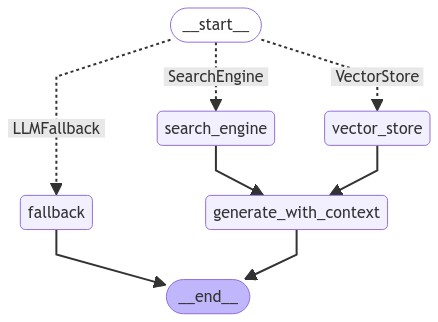

OutputParserException: Invalid json output: Based on the provided documents, the current president of Iran is not explicitly mentioned. However, we can infer some information about the presidency of Iran and the recent events related to it.

From Document 1, we learn about the powers and responsibilities of the President of Iran, including the oath of office, duties, and limitations. The document also mentions that the President is elected for a four-year term and can be reelected only once in a consecutive manner.

Document 2 provides a list of presidents of Iran since 1980, but it does not mention the current president.

Document 3 is an article from CNN, which reports on the death of President Ebrahim Raisi in office. However, this information is not consistent with the other documents, which suggest that Ebrahim Raisi is still alive and holding the office of the President of Iran.

Document 4 provides information about Ebrahim Raisi, including his background, executive and oversight responsibilities, and his statements on various issues. This document suggests that Ebrahim Raisi is indeed the current President of Iran.

Finally, Document 5 is an article from BBC News, which reports on the election of a new president in Iran following the death of the former incumbent, Ebrahim Raisi. However, this information is inconsistent with the other documents, which suggest that Ebrahim Raisi is still alive and holding the office of the President of Iran.

Based on the analysis of these documents, it appears that Ebrahim Raisi is the current President of Iran. However, there is some inconsistency in the information provided, which may suggest that the documents are not up-to-date or that there has been a recent change in the presidency of Iran.

In [115]:
# Define the AgentState class
class AgentState(TypedDict):
    query: str
    chat_history: List[BaseMessage]
    generation: str
    documents: List[Document]

# Router Chain
router_prompt_template = ChatPromptTemplate.from_template(
    template="""
    You have to choose routing user queries to either a VectorStore, a SearchEngine, or Fallback (None).
    Your VectorStore contains data about natural language processing, computer science, and general topics. If the given query is about one of these topics, choose VectorStore.
    If the query is not related to any of these topics, choose SearchEngine.
    If the query is not related to anything the chatbot can handle, give back the string None.
    Provide only the name of the tool you chose in a JSON object with the key "tool_name".
    Response format: {{"tool_name": "YourChoice"}}
    Query: {query}
    """
)
llm = ChatTogether(
    model_name="meta-llama/Llama-3-70b-chat-hf",
    temperature=0.7
)
class ChosenTool(BaseModel):
    tool_name: Literal['None', "VectorStore", "SearchEngine"]

question_router_parser = PydanticOutputParser(pydantic_object=ChosenTool)
router_chain = router_prompt_template | llm | question_router_parser

# Search Engine Chain
search_tool = TavilySearchResults()
def search_engine_chain(query):
    search_results = search_tool.invoke(query)
    documents = [Document(page_content=result['content'], metadata={"source": result['url']}) for result in search_results[:5]]
    return {"documents": documents}

# Define the nodes
def retrieve_node(state: AgentState):
    query = state["query"]
    documents = create_retriever_and_perform_retrieval(vector_store, query)
    return {"documents": documents}

def fallback_node(state: AgentState):
    query = state["query"]
    chat_history = state["chat_history"]
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history}).content
    return {"generation": generation}

def generate_with_context_node(state: AgentState):
    query = state["query"]
    documents = state["documents"]
    generation = generate_with_context_chain.invoke({"query": query, "documents": documents}).content
    return {"generation": generation}

def question_router_node(state: AgentState):
    query = state["query"]
    try:
        response = router_chain.invoke({"query": query, "output_instructions": question_router_parser.get_format_instructions()})
        # Attempt to parse JSON response
        try:
            chosen_tool = response.tool_name.lower()
        except AttributeError:
            # Fallback to plain text handling
            chosen_tool = response.lower().strip()
    except Exception as e:
        print(f"Error invoking router chain: {e}")
        return "LLMFallback"

    if chosen_tool == 'none':
        return "LLMFallback"
    if chosen_tool == "vectorstore":
        return "VectorStore"
    if chosen_tool == "searchengine":
        return "SearchEngine"
    return "LLMFallback"

# Define the Graph
workflow = StateGraph(AgentState)

workflow.add_node("vector_store", retrieve_node)
workflow.add_node("search_engine", search_engine_chain)  # Add search_engine node
workflow.add_node("fallback", fallback_node)
workflow.add_node("generate_with_context", generate_with_context_node)

workflow.set_conditional_entry_point(
    question_router_node,
    {
        "LLMFallback": "fallback",
        "VectorStore": "vector_store",
        "SearchEngine": "search_engine",
    },
)

workflow.add_edge("vector_store", "generate_with_context")
workflow.add_edge("search_engine", "generate_with_context")
workflow.add_edge("generate_with_context", END)
workflow.add_edge("fallback", END)

# Compile and run the graph
app = workflow.compile(debug=False)
plot = app.get_graph().draw_mermaid_png()

with open("plot.png", "wb") as fp:
    fp.write(plot)

img = Image.open(BytesIO(plot))
display(img)

response = app.invoke({"query": "who is the president of Iran?", "chat_history": []})
display(Markdown(response["generation"]))

# Create the Gradio interface
history = {}
session_id = str(uuid4())

def chat(query):
    # Initialize the chat history for the current session
    if session_id not in history:
        history[session_id] = []

    chat_history = history[session_id]

    # Invoke the app with the current query and chat history
    result = app.invoke({"query": query, "chat_history": chat_history})

    # Separate the response from the retrieved documents
    response = result["generation"]
    documents = result.get("documents", [])

    # Add the current exchange to the chat history
    chat_history.extend([HumanMessage(content=query), AIMessage(content=response)])

    if not documents:
        return response, ""

    documents_text = "\n\n".join([f"{doc.page_content}\nsource: {doc.metadata['source']}" for doc in documents])

    return response, documents_text

# Create the Gradio interface
demo = gr.Interface(
    fn=chat,
    inputs=gr.Textbox(label="Question"),
    outputs=[gr.Textbox(label="Response"), gr.Textbox(label="Retrieved Documents")],
    title="RAG Chatbot",
    description="Ask a query and the chatbot will generate a response using Retrieval Augmented Generation.",
)

# demo.launch(share=True, inline=True)
